In [17]:
import sys

sys.path.append("..")
from src.models.tfidf_baseline import TfidfBaselineModel
import pandas as pd
import numpy as np
import os
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [20]:
plt.style.use("ggplot")

In [3]:
DATA_DIR = os.path.abspath(os.path.join(os.getcwd(), "../", "data"))
NAICS_DATA = os.path.join(DATA_DIR, "processed/coverwallet_preprocessed.parquet")
SYNTHETIC_DATA = os.path.join(DATA_DIR, "processed/synthetic_preprocessed.parquet")

In [4]:
df = pd.read_parquet(NAICS_DATA)
synthetic_df = pd.read_parquet(SYNTHETIC_DATA)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    df["PREPROCESSED_DESCRIPTION"],
    df["NAICS_2"],
    test_size=0.2,
    random_state=42,
    stratify=df["NAICS_2"],
)

In [6]:
# add synthetic data to training data
X_train = pd.concat([X_train, synthetic_df["PREPROCESSED_DESCRIPTION"]])
y_train = pd.concat([y_train, synthetic_df["NAICS_2"]])

In [7]:
# train best svm
model = Pipeline(
    [
        ("vectorizer_tfidf", TfidfVectorizer()),
        ("SVC", SVC(C=1, kernel="linear")),
    ]
)

model.fit(X_train, y_train)

Pipeline(steps=[('vectorizer_tfidf', TfidfVectorizer()),
                ('SVC', SVC(C=1, kernel='linear'))])

In [8]:
y_pred = model.predict(X_test)

In [14]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

          11       0.33      0.20      0.25         5
          21       0.00      0.00      0.00         3
          22       0.17      0.17      0.17         6
          23       0.82      0.89      0.86       595
          31       0.40      0.43      0.42        37
          32       0.68      0.35      0.47        48
          33       0.62      0.59      0.60       136
          42       0.57      0.63      0.60       130
          44       0.54      0.23      0.33        30
          45       0.45      0.27      0.34        48
          48       0.80      0.74      0.77        54
          49       0.80      0.44      0.57         9
          51       0.54      0.26      0.35        76
          52       0.77      0.84      0.81        32
          53       0.76      0.67      0.71        66
          54       0.72      0.88      0.79       841
          55       0.00      0.00      0.00         3
          56       0.79    

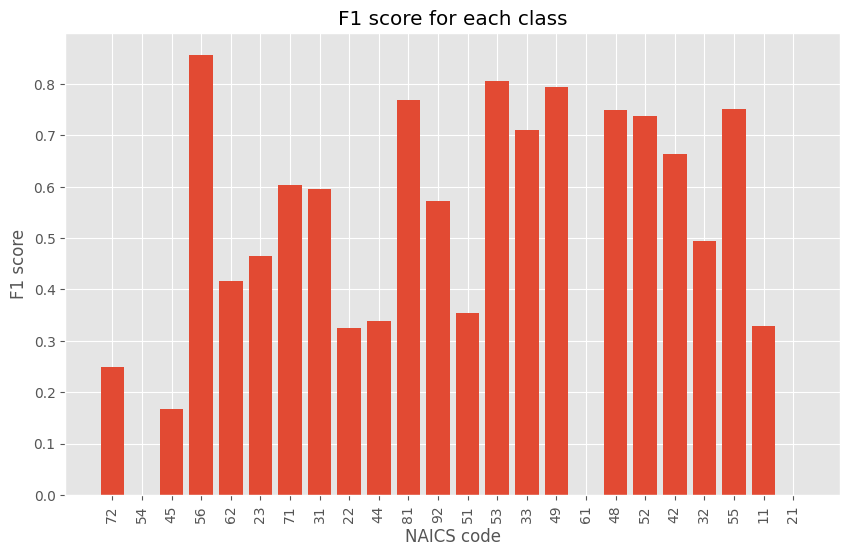

In [21]:
# get F1 for each class
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred, average=None)

# plot F1 for each class
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(f1)), f1)
plt.xlabel("NAICS code")
plt.ylabel("F1 score")
plt.title("F1 score for each class")
plt.xticks(np.arange(len(f1)), df["NAICS_2"].unique(), rotation=90)
plt.show()

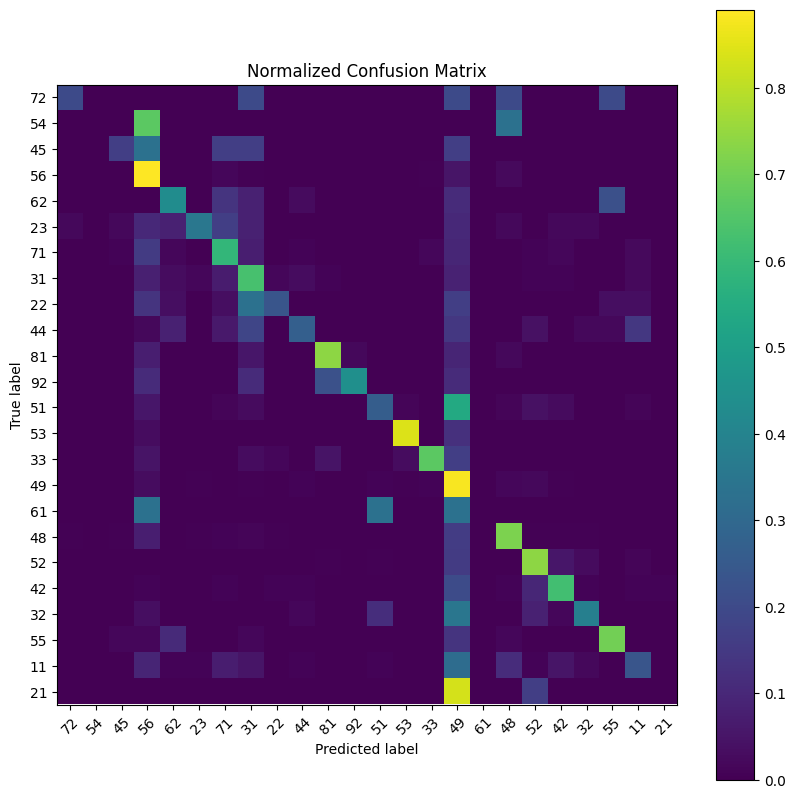

In [12]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

# normalize the confusion matrix
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  #

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation="nearest")
plt.title("Normalized Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(df["NAICS_2"].unique()))
plt.xticks(tick_marks, df["NAICS_2"].unique(), rotation=45)
plt.yticks(tick_marks, df["NAICS_2"].unique())

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

Let's get if there are common characteristics for the wrongly classified samples.


In [35]:
is_wrongly_predicted = np.array(y_test) != y_pred
is_wrongly_predicted

array([False,  True,  True, ...,  True,  True, False])

In [54]:
# get the wrongly classified samples
wrongly_classified_descriptions = X_test[is_wrongly_predicted]
wrongly_classified_df = df.loc[wrongly_classified_descriptions.index]

In [55]:
# join the wrongly classified samples with the predicted and true labels
wrongly_classified_df["predicted"] = y_pred[is_wrongly_predicted]

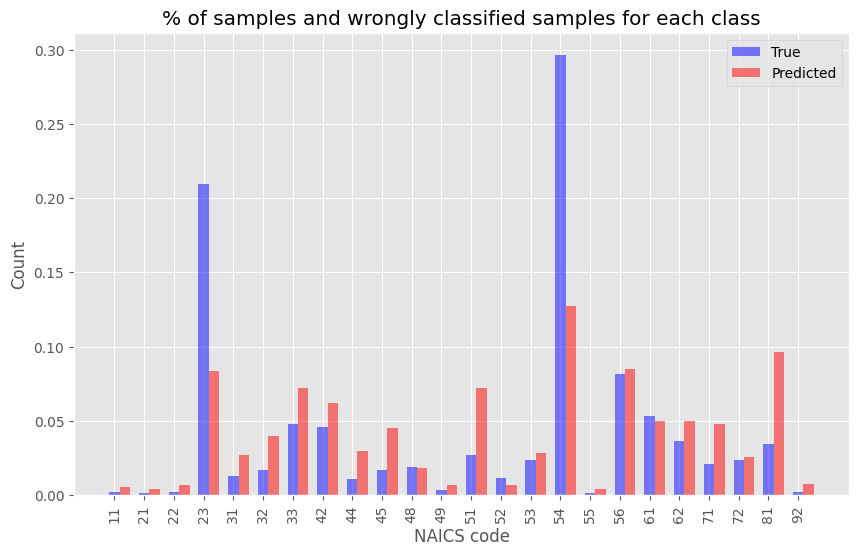

In [79]:
# grouped bar plot of true and predicted labels normalized by the number of samples in the test set
plt.figure(figsize=(10, 6))
barWidth = 0.35
r1 = np.arange(len(wrongly_classified_df["NAICS_2"].value_counts()))
r2 = [x + barWidth for x in r1]

plt.bar(
    r1,
    y_test.value_counts().sort_index() / len(y_test),
    color="b",
    width=barWidth,
    label="True",
    alpha=0.5,
)
plt.bar(
    r2,
    wrongly_classified_df["NAICS_2"].value_counts().sort_index()
    / len(wrongly_classified_df["NAICS_2"]),
    color="r",
    width=barWidth,
    label="Predicted",
    alpha=0.5,
)
plt.xlabel("NAICS code")
plt.ylabel("Count")
plt.title("% of samples and wrongly classified samples for each class")
plt.xticks(np.arange(len(wrong_count)), wrong_count.index, rotation=90)
plt.legend()
plt.show()

As we can see in the plot, there are some classes that have more percentage of wrongly classified samples than the proportion of the samples in the dataset. This shows that the model has more difficulties to classify some classes than others.
